# Imports

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h2o
from sklearn.model_selection import train_test_split
from sklego.preprocessing import RepeatingBasisFunction
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.preprocessing import MinMaxScaler


(CVXPY) Nov 06 01:09:53 PM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/Users/joakimness/anaconda3/envs/tdt4173/lib/python3.9/site-packages/_scs_direct.cpython-39-darwin.so, 0x0002): Library not loaded: @rpath/liblapack.3.dylib\n  Referenced from: <F9700F1C-290B-3DF3-8D09-CFDF44BAE051> /Users/joakimness/anaconda3/envs/tdt4173/lib/python3.9/site-packages/_scs_direct.cpython-39-darwin.so\n  Reason: tried: '/Users/joakimness/anaconda3/envs/tdt4173/lib/python3.9/site-packages/../../liblapack.3.dylib' (no such file), '/Users/joakimness/anaconda3/envs/tdt4173/lib/python3.9/site-packages/../../liblapack.3.dylib' (no such file), '/Users/joakimness/anaconda3/envs/tdt4173/bin/../lib/liblapack.3.dylib' (no such file), '/Users/joakimness/anaconda3/envs/tdt4173/bin/../lib/liblapack.3.dylib' (no such file), '/usr/local/lib/liblapack.3.dylib' (no such file), '/usr/lib/liblapack.3.dylib' (no such file, not in dyld cache)")


In [2]:
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

raw_b = train_b

X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')

In [ ]:
X_train_observed_a.to_csv('X_train_observed_a.csv')
X_train_estimated_a.to_csv('X_train_estimated_a.csv')
X_test_estimated_a.to_csv('X_test_estimated_a.csv')

# Preprocessing

In [13]:
agg_dict = {
    'absolute_humidity_2m:gm3': 'median',
    'air_density_2m:kgm3': 'median',
    'ceiling_height_agl:m': 'median',
    'clear_sky_energy_1h:J': 'sum',
    'clear_sky_rad:W': 'median',
    'cloud_base_agl:m': 'median',
    'dew_or_rime:idx': 'median',
    'dew_point_2m:K': 'median',
    'diffuse_rad:W': 'median',
    'diffuse_rad_1h:J': 'sum',
    'direct_rad:W': 'median',
    'direct_rad_1h:J': 'sum',
    'effective_cloud_cover:p': 'median',
    'elevation:m': 'median',
    'fresh_snow_12h:cm': 'sum',
    'fresh_snow_1h:cm': 'sum',
    'fresh_snow_24h:cm': 'sum',
    'fresh_snow_3h:cm': 'sum',
    'fresh_snow_6h:cm': 'sum',
    'is_day:idx': 'median',  
    'is_in_shadow:idx': 'median',  
    'msl_pressure:hPa': 'median',
    'precip_5min:mm': 'sum',
    'precip_type_5min:idx': 'median',  
    'pressure_100m:hPa': 'median',
    'pressure_50m:hPa': 'median',
    'prob_rime:p': 'median',
    'rain_water:kgm2': 'sum',
    'relative_humidity_1000hPa:p': 'median',
    'sfc_pressure:hPa': 'median',
    'snow_density:kgm3': 'median',
    'snow_depth:cm': 'median',
    'snow_drift:idx': 'median',
    'snow_melt_10min:mm': 'sum',
    'snow_water:kgm2': 'sum',
    'sun_azimuth:d': 'median',
    'sun_elevation:d': 'median',
    'super_cooled_liquid_water:kgm2': 'sum',
    't_1000hPa:K': 'median',
    'total_cloud_cover:p': 'median',
    'visibility:m': 'median',
    'wind_speed_10m:ms': 'median',
    'wind_speed_u_10m:ms': 'median',
    'wind_speed_v_10m:ms': 'median',
    'wind_speed_w_1000hPa:ms': 'median'
}

def preprocessing_X(df):
    data = df.copy()
    if 'date_calc' in data.columns:
        data.drop('date_calc', axis=1, inplace=True)

    if 'date_forecast' in data.columns:
        data.set_index('date_forecast', inplace=True)

    
    #TODO: prøv også agg(agg_dict)
    #data = data.resample('60min').agg(agg_dict)
    data = data.groupby(pd.Grouper(freq='1H')).mean()
    #data = data.groupby(pd.Grouper(freq='1H')).agg(agg_dict)
    
    
    data.dropna(how='all', inplace=True)
    
    data['hour'] = data.index.hour
    data['week'] = pd.to_numeric(data.index.isocalendar().week)
    data['week_hour'] = data['week'] * 100 + data['hour']
    data['month'] = data.index.month


    #TODO: prøv annen encoding her
    data['hour_sinus'] = np.sin(2*np.pi*data['hour']/ 23)
    data['hour_cosine'] = np.cos(2*np.pi*data['hour'] / 23)

    data['month_sinus'] = np.sin(2*np.pi*data['month'] / 12)
    data['month_cosine'] = np.cos(2*np.pi*data['month'] / 12)

    

    data.drop(columns=['snow_density:kgm3', 'month', 'hour', 'week','week_hour'], inplace=True)
    
    data.rename_axis('time', inplace=True)

    mapping = elevation_mapping = {
            6.0 : 'A',
            7.0 : 'B',
            24.0 : 'C'
        }
    
    data['location'] = data['elevation:m'].map(mapping)
    data['location'] = data['location'].astype(str)
    data.drop(columns=['elevation:m'], inplace=True)
    
    return data

def remove_constants_Y(df):
    data = df.copy()

    # Create a mask to identify sequences of 3 or more consecutive rows with the same 'pv_measurement' (non-zero)
    consecutive_mask = (data['pv_measurement'] == data['pv_measurement'].shift(1)) & (data['pv_measurement'] != 0)
    consecutive_count = consecutive_mask.groupby((~consecutive_mask).cumsum()).cumsum()
    mask_consecutive = (consecutive_count <= 3) | (~consecutive_mask)

    #create a mask to identify sequences of 24 or more consecutive 0-valued pv-measurement
    consecutive_mask_0 = (data['pv_measurement'] == data['pv_measurement'].shift(1)) & (data['pv_measurement'] == 0)
    consecutive_count_0 = consecutive_mask_0.groupby((~consecutive_mask_0).cumsum()).cumsum()
    mask_consecutive_0 = (consecutive_count_0 <= 24) | (~consecutive_mask_0)

    combined_mask = mask_consecutive & mask_consecutive_0

    filtered_data = data[combined_mask]

    return filtered_data


def preprocessing_Y(df):
    data = df.copy()
    if 'time' in data.columns:
        data.set_index('time', inplace=True)
    data.dropna(inplace=True)
    
    return data


def generating_avgmeas(df): 
    data = df.copy()
    for location in data['location'].unique():
        # Filter the DataFrame for the current loc_flag value
        filtered_df = data[data['location'] == location]
        
        # Group the filtered DataFrame by 'month' and calculate the mean 'pv_measurement'
        avg_measurement_by_month = filtered_df.groupby('week_hour')['pv_measurement'].mean()
        
        # Convert the result to a dictionary
        avg_measurement_dict = avg_measurement_by_month.to_dict()
        
        # Assign the result to the appropriate dictionary based on loc_flag value
        if location == 'A':
            average_measurement_a = avg_measurement_dict
        elif location == 'B':
            average_measurement_b = avg_measurement_dict
        elif location == 'C':
            average_measurement_c = avg_measurement_dict
    return average_measurement_a, average_measurement_b, average_measurement_c

def add_avgmeas(average_measurement_a, average_measurement_b, average_measurement_c, df):
    data = df.copy()
    data['average_measurement'] = data.apply(lambda row: average_measurement_a[row['week_hour']]
                                            if row['location'] == 'A'
                                            else (average_measurement_b[row['week_hour']]
                                                if row['location'] == 'B'
                                                else average_measurement_c[row['week_hour']]), axis=1)
    
    data.drop(columns=['week_hour'], inplace=True)
    return data

def add_estimated_flag(df, estimated):
    data = df.copy()

    data['estimated'] = 'E' if estimated else 'O'

    return data

#TODO: FIX
def rbf_function(df,column_name,N_PERIODS):
    rbf = RepeatingBasisFunction(n_periods=N_PERIODS,
                            remainder='passthrough',
                            column=column_name,
                            input_range=(df[column_name].min() ,df[column_name].max()))
    rbf.fit(df)
    data_period = pd.DataFrame(rbf.transform(df), columns=df.columns)
    return data_period


#TODO: Legg til average measurement funksjonalitet her igjenF


In [14]:
transformed_train_a = train_a.copy()
transformed_train_b = train_b.copy()
transformed_train_c = train_c.copy()

scaler_a = MinMaxScaler()
scaler_b = MinMaxScaler()
scaler_c = MinMaxScaler()

transformed_train_a['pv_measurement'] = scaler_a.fit_transform(train_a[['pv_measurement']])
transformed_train_b['pv_measurement'] = scaler_b.fit_transform(train_b[['pv_measurement']])
transformed_train_c['pv_measurement'] = scaler_c.fit_transform(train_c[['pv_measurement']])

#combining observed and estimated data
observed_a = preprocessing_X(X_train_observed_a)
observed_a = add_estimated_flag(observed_a, False)

estimated_a = preprocessing_X(X_train_estimated_a)
estimated_a = add_estimated_flag(estimated_a, True)


x_train_a = pd.concat([observed_a, estimated_a], axis=0)
y_train_a = preprocessing_Y(train_a)
m_train_a = x_train_a.merge(y_train_a, how='inner', on='time')

transformed_y_train_a = preprocessing_Y(transformed_train_a)
transformed_m_train_a = x_train_a.merge(transformed_y_train_a, how='inner', on='time')

observed_b = preprocessing_X(X_train_observed_b)
observed_b = add_estimated_flag(observed_b, False)

estimated_b = preprocessing_X(X_train_estimated_b)
estimated_b = add_estimated_flag(estimated_b, True)

x_train_b = pd.concat([observed_b, estimated_b], axis=0)
y_train_b = preprocessing_Y(train_b)
y_train_b = remove_constants_Y(y_train_b)
m_train_b = x_train_b.merge(y_train_b, how='inner', on='time')

transformed_y_train_b = preprocessing_Y(transformed_train_b)
transformed_y_train_b = remove_constants_Y(transformed_y_train_b)
transformed_m_train_b = x_train_b.merge(transformed_y_train_b, how='inner', on='time')

observed_c = preprocessing_X(X_train_observed_c)
observed_c = add_estimated_flag(observed_c, False)

estimated_c = preprocessing_X(X_train_estimated_c)
estimated_c = add_estimated_flag(estimated_c, True)


x_train_c = pd.concat([observed_c, estimated_c], axis=0)
y_train_c = preprocessing_Y(train_c)
y_train_c = remove_constants_Y(y_train_c)
m_train_c = x_train_c.merge(y_train_c, how='inner', on='time')

transformed_y_train_c = preprocessing_Y(transformed_train_c)
transformed_y_train_c = remove_constants_Y(transformed_y_train_c)
transformed_m_train_c = x_train_c.merge(transformed_y_train_c, how='inner', on='time')

x_train = pd.concat([m_train_a, m_train_b, m_train_c], axis=0, ignore_index=True)

transformed_x_train = pd.concat([transformed_m_train_a, transformed_m_train_b, transformed_m_train_c], axis=0, ignore_index=True)


y_train = x_train['pv_measurement']
transformed_y_train = transformed_x_train['pv_measurement']

x_train = x_train.drop(columns=['pv_measurement'], axis=1)
transformed_x_train = transformed_x_train.drop(columns=['pv_measurement'], axis=1)

X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, random_state=10)
transformed_X_train, transformed_X_val, transformed_Y_train, transformed_Y_val = train_test_split(transformed_x_train, transformed_y_train, test_size=0.2, shuffle=True, random_state=10)

X_train_a = X_train[X_train['location'] == 'A']
X_train_b = X_train[X_train['location'] == 'B']
X_train_c = X_train[X_train['location'] == 'C']

transformed_X_train_a = transformed_X_train[transformed_X_train['location'] == 'A']
transformed_X_train_b = transformed_X_train[transformed_X_train['location'] == 'B']
transformed_X_train_c = transformed_X_train[transformed_X_train['location'] == 'C']

Y_train_a = Y_train[X_train['location'] == 'A']
Y_train_b = Y_train[X_train['location'] == 'B']
Y_train_c = Y_train[X_train['location'] == 'C']

transformed_Y_train_a = transformed_Y_train[transformed_X_train['location'] == 'A']
transformed_Y_train_b = transformed_Y_train[transformed_X_train['location'] == 'B']
transformed_Y_train_c = transformed_Y_train[transformed_X_train['location'] == 'C']

X_val_a = X_val[X_val['location'] == 'A']
X_val_b = X_val[X_val['location'] == 'B']
X_val_c = X_val[X_val['location'] == 'C']

transformed_X_val_a = transformed_X_val[transformed_X_val['location'] == 'A']
transformed_X_val_b = transformed_X_val[transformed_X_val['location'] == 'B']
transformed_X_val_c = transformed_X_val[transformed_X_val['location'] == 'C']

Y_val_a = Y_val[X_val['location'] == 'A']
Y_val_b = Y_val[X_val['location'] == 'B']
Y_val_c = Y_val[X_val['location'] == 'C']

transformed_Y_val_a = transformed_Y_val[transformed_X_val['location'] == 'A']
transformed_Y_val_b = transformed_Y_val[transformed_X_val['location'] == 'B']
transformed_Y_val_c = transformed_Y_val[transformed_X_val['location'] == 'C']


x_test_a = preprocessing_X(X_test_estimated_a)
x_test_a = add_estimated_flag(x_test_a, True)

x_test_b = preprocessing_X(X_test_estimated_b)
x_test_b = add_estimated_flag(x_test_b, True)

x_test_c = preprocessing_X(X_test_estimated_c)
x_test_c = add_estimated_flag(x_test_c, True)






x_test = pd.concat([x_test_a, x_test_b, x_test_c], axis=0, ignore_index=True)

In [ ]:
74647
X_train.to_csv('X_train.csv')
Y_train.to_csv('Y_train.csv')
X_val.to_csv('X_val.csv')
Y_val.to_csv('Y_val.csv')

# EDA

## Domain knowledge


The group carried out research to obtain domain knowledge. The group used the weather parameter description provided in the Kaggle tournament (https://www.meteomatics.com/en/api/available-parameters/alphabetic-list/).

It was important to understand the dataset during feature engineering, understanding which features were most important and during pre/post-processing.

## Checking if data is intuitive

To get a good overview of the data we created plots for each feature. By doing this, the group identified several anomalies and inconsistencies among the features.

### Constant values in PV-measurement and gaps

Observed recurring gaps, zero and non-zero values, indicating faulty measurements. Which was dealt with during pre-processing, by dropping these rows.

### Different time stamps: Every 15 minutes and hourly

We observed that the datasets containing all the features (X_data) were aggregated to every 15 minutes, while the target values (PV-measurement) were aggregated every 1 hour. We dealt with this during pre-processing by aggregating from every 15 minutes to 1 hour by taking the mean values.

### NaN values in snow_density

Identified many NaN values in snow_density, so the group dropped the whole column.

### Observed/Estimated

The group looked at the transition between observed and estimated data. Realizing a large time gap between the two. The group decided not to adress this gap, other than flagging estimated and observed data. Which turned into an important cat_feature. 

## Understand how the data was generated

### Measurement errors observed

As previously mentioned, the group had to make assumptions about data inconsistencies. For example that large time gaps was because of faulty measurements, leading to the group dropping this data as it was noisy.

### Estimated inconsistencies

The group had a realistic approach to the estimated data. The fact that they are predictions from a meteorologist means that they are not accurate, and is a source of error. Differing from observed data that is historical data. It is also important to realize that observed data may not repeat itself in the future. That is why we avoided interpolation of earlier data.

## Explore individual features

As previously elaborated upon, the group explored individual features. Feature importance plots were also important to understand which features our models viewed as most important. This will be further discussed in the *Feature important* section.

This information was further used to choose features to drop i.e. snow_density, and features we could further feature engineer, which will be discussed further in the *Feature engineering* section.

## Explore pairs and groups of features

### Correlation matrix

The group created a correlation matrix for each location to aid in feature selection. Features with high correlation may be linearly dependent, meaning they often impact the dependent variable in a similar manner. Therefore, if two features have high correlation, it could be wise to remove one of them to reduce noise. However, the group decided not to drop such features, because we got good results with them included.

***TODO*** Corr. plot

### Wind features

In [ ]:
#exploratory data analysis and vizualization 
columns = x_train_a.columns.to_list()

for el in columns: 
    # Plotting the pv_measurement over time for locations A, B, and C
    plt.figure(figsize=(20, 15))

    # Location A
    plt.subplot(3, 1, 1)
    plt.plot(x_train_a[el], label='Location A', color='blue')
    plt.title(f'Solar Energy Production {el} over Time for Location A')
    plt.xlabel('Time')
    plt.ylabel('Solar Energy Production')
    plt.legend()
    plt.grid(True)

    # Location B
    plt.subplot(3, 1, 2)
    plt.plot(x_train_b[el], label='Location B', color='green')
    plt.title(f'Solar Energy Production {el} over Time for Location B')
    plt.xlabel('Time')
    plt.ylabel('Solar Energy Production')
    plt.legend()
    plt.grid(True)

    # Location C
    plt.subplot(3, 1, 3)
    plt.plot(x_train_c[el], label='Location C', color='red')
    plt.title(f'Solar Energy Production {el} over Time for Location C')
    plt.xlabel('Time')
    plt.ylabel('Solar Energy Production')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()






# Catboost

In [19]:
from catboost import CatBoostRegressor
from catboost import Pool

params = {
    'depth' : 9,
    'iterations' : 1000,
    'loss_function' : 'MAE'
}

def catboost(X_train, Y_train, X_val, Y_val):
    
    model = CatBoostRegressor(**params)

    train_pool = Pool(data=X_train, label=Y_train, cat_features=['location', 'estimated'])

    eval_pool = Pool(data=X_val, label=Y_val, cat_features=['location', 'estimated'])

    model.fit(train_pool, use_best_model=True, eval_set=eval_pool)
    return model 



def train_predict(single=False):
    lenlist = []
    if not single:

        model = catboost(X_train, Y_train, X_val, Y_val)
        
        predictions = pd.DataFrame(model.predict(x_test), columns=['prediction'])

        predictions.index.name = 'id'

        return predictions, model

    else:
        model_a = catboost(X_train_a, Y_train_a, X_val_a, Y_val_a)
        predict_a = model_a.predict(x_test_a)
        predictions_a = pd.DataFrame(predict_a, columns=['prediction'])
        
        lenlist.append(len(predictions_a))

        model_b = catboost(X_train_b, Y_train_b, X_val_b, Y_val_b)
        predict_b = model_b.predict(x_test_b)
        predictions_b = pd.DataFrame(predict_b, columns=['prediction'])

        lenlist.append(len(predictions_b))
        
        model_c = catboost(X_train_c, Y_train_c, X_val_c, Y_val_c)
        predict_c = model_c.predict(x_test_c)
        predictions_c = pd.DataFrame(predict_c, columns=['prediction'])

        lenlist.append(len(predictions_c))

        predictions = pd.concat([predictions_a, predictions_b, predictions_c], axis=0, ignore_index=True)

        predictions.index.name = 'id'

        return predictions, model_a, model_b, model_c



def transformed_train_predict(single=False):
    if not single:

        model = catboost(transformed_X_train, transformed_Y_train, transformed_X_val, transformed_Y_val)
        
        predictions = pd.DataFrame(model.predict(x_test), columns=['prediction'])

        predictions.index.name = 'id'

        return predictions, model

    else:
        model_a = catboost(transformed_X_train_a, transformed_Y_train_a, transformed_X_val_a, transformed_Y_val_a)
        predict_a = model_a.predict(x_test_a)
        predictions_a = pd.DataFrame(predict_a, columns=['prediction'])
        predictions_a.loc[:, 'prediction'] = scaler_a.inverse_transform(predictions_a['prediction'].values.reshape(-1, 1))
        

        model_b = catboost(transformed_X_train_b, transformed_Y_train_b, transformed_X_val_b, transformed_Y_val_b)
        predict_b = model_b.predict(x_test_b)
        predictions_b = pd.DataFrame(predict_b, columns=['prediction'])
        predictions_b.loc[:, 'prediction'] = scaler_b.inverse_transform(predictions_b['prediction'].values.reshape(-1, 1))

        
        model_c = catboost(transformed_X_train_c, transformed_Y_train_c, transformed_X_val_c, transformed_Y_val_c)
        predict_c = model_c.predict(x_test_c)
        predictions_c = pd.DataFrame(predict_c, columns=['prediction'])
        predictions_c.loc[:, 'prediction'] = scaler_c.inverse_transform(predictions_c['prediction'].values.reshape(-1, 1))


        predictions = pd.concat([predictions_a, predictions_b, predictions_c], axis=0, ignore_index=True)


        predictions.index.name = 'id'
        

        return predictions, model_a, model_b, model_c





In [21]:
predictions, model_a, model_b, model_c = train_predict(single=True)

0:	learn: 609.4517455	test: 637.6052708	best: 637.6052708 (0)	total: 27.1ms	remaining: 27.1s
1:	learn: 598.5068431	test: 626.7081969	best: 626.7081969 (1)	total: 37.5ms	remaining: 18.7s
2:	learn: 585.4067416	test: 613.3868237	best: 613.3868237 (2)	total: 47.7ms	remaining: 15.9s
3:	learn: 571.9478643	test: 599.7856574	best: 599.7856574 (3)	total: 57.5ms	remaining: 14.3s
4:	learn: 558.4536945	test: 586.2005389	best: 586.2005389 (4)	total: 66.8ms	remaining: 13.3s
5:	learn: 547.8445927	test: 575.6325521	best: 575.6325521 (5)	total: 76.5ms	remaining: 12.7s
6:	learn: 534.0477976	test: 561.4060082	best: 561.4060082 (6)	total: 86.3ms	remaining: 12.2s
7:	learn: 521.6373886	test: 548.6515287	best: 548.6515287 (7)	total: 96.2ms	remaining: 11.9s
8:	learn: 508.9158328	test: 535.5494145	best: 535.5494145 (8)	total: 106ms	remaining: 11.7s
9:	learn: 497.2895478	test: 523.7440918	best: 523.7440918 (9)	total: 116ms	remaining: 11.5s
10:	learn: 487.9145009	test: 514.4818512	best: 514.4818512 (10)	total: 1

In [ ]:
transformed_catboost_predictions = transformed_train_predict(single=True)

## Feature importance

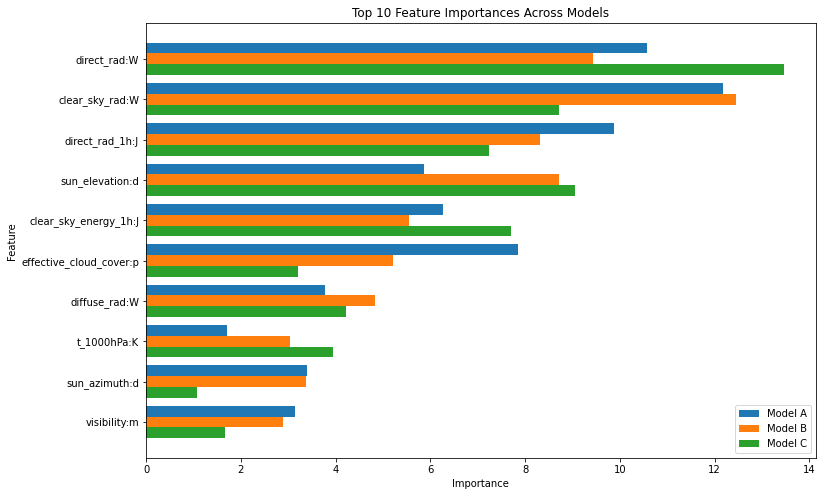

In [39]:
def plot_combined_feature_importances(models, model_names, n_features_to_plot=10):
    all_feature_importances = []
    
    # Assuming all models have the same features in the same order
    feature_names = models[0].feature_names_

    # Gather feature importances for each model
    for model in models:
        feature_importances = model.get_feature_importance(
            data=None,
            reference_data=None,
            prettified=False,
            thread_count=-1,
            verbose=False
        )
        all_feature_importances.append(feature_importances)

    # Create DataFrame
    feature_importances_df = pd.DataFrame(all_feature_importances, columns=feature_names, index=model_names).transpose()

    # Sort the DataFrame by the average importance across models and take top N for plotting
    feature_importances_df['Average'] = feature_importances_df.mean(axis=1)
    sorted_feature_importances_df = feature_importances_df.sort_values(by='Average', ascending=False).head(n_features_to_plot)

    # Drop the average as we no longer need it
    sorted_feature_importances_df = sorted_feature_importances_df.drop('Average', axis=1)
    
    # Plotting
    plt.figure(figsize=(12, 8))

    # Create the bar positions
    total_width = 0.8
    n_models = len(models)
    individual_width = total_width / n_models
    bar_positions = np.arange(n_features_to_plot)

    for i, model_name in enumerate(model_names):
        plt.barh(bar_positions + i * individual_width, sorted_feature_importances_df[model_name], height=individual_width, label=model_name)

    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Top {n_features_to_plot} Feature Importances Across Models')
    plt.yticks(bar_positions + individual_width * (n_models - 1) / 2, sorted_feature_importances_df.index)
    plt.gca().invert_yaxis()  # To display the highest importance at the top
    plt.legend()
    plt.show()

# List of models and their names
models = [model_a, model_b, model_c]
model_names = ['Model A', 'Model B', 'Model C']

# Now call the function
plot_combined_feature_importances(models, model_names)


# XGBoost

In [ ]:
from xgboost import XGBRegressor

def xgboost(X_train, Y_train, X_val, Y_val):

    xgb_mapping = elevation_mapping = {
                'A': -1,
                'B': 0,
                'C': 1
            }

    X_train_xgb = X_train.copy()
    X_train_xgb['location'] = X_train_xgb['location'].map(xgb_mapping) 

    X_val_xgb = X_val.copy()
    X_val_xgb['location'] = X_val_xgb['location'].map(xgb_mapping)

    #Sinan added this to fix for test also
    x_test_a['location'] = x_test_a['location'].map(xgb_mapping)
    x_test_b['location'] = x_test_b['location'].map(xgb_mapping)
    x_test_c['location'] = x_test_c['location'].map(xgb_mapping)

    xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.125, n_jobs=3,eval_metric='mae')

    eval_set = [(X_val_xgb, Y_val)]

    xgb_model.fit(X_train_xgb, Y_train, eval_set=eval_set,early_stopping_rounds=500)
    return xgb_model

def xgboost_train_predict(single=False):
    lenlist = []
    if not single:

        xgbmodel = xgboost(X_train, Y_train, X_val, Y_val)
        
        predictions = pd.DataFrame(xgbmodel.predict(x_test), columns=['prediction'])

        predictions.index.name = 'id'

        return predictions, xgbmodel

    else:
        model_a = xgboost(X_train_a, Y_train_a, X_val_a, Y_val_a)
        predict_a = model_a.predict(x_test_a)
        predictions_a = pd.DataFrame(predict_a, columns=['prediction'])
        
        lenlist.append(len(predictions_a))

        model_b = xgboost(X_train_b, Y_train_b, X_val_b, Y_val_b)
        predict_b = model_b.predict(x_test_b)
        predictions_b = pd.DataFrame(predict_b, columns=['prediction'])

        lenlist.append(len(predictions_b))
        
        model_c = xgboost(X_train_c, Y_train_c, X_val_c, Y_val_c)
        predict_c = model_c.predict(x_test_c)
        predictions_c = pd.DataFrame(predict_c, columns=['prediction'])

        lenlist.append(len(predictions_c))

        predictions = pd.concat([predictions_a, predictions_b, predictions_c], axis=0, ignore_index=True)

        lenlist.append(len(predictions))

        predictions.index.name = 'id'

        return predictions, model_a, model_b, model_c, lenlist

In [ ]:
predictions, model_a, model_b, model_c, lenlist = xgboost_train_predict(single=True)
print(f'A:{model_a.best_score}')
print(f'B:{model_b.best_score}')
print(f'C:{model_c.best_score}')
print(lenlist)

In [ ]:
A:178.2044953089704
B:28.502522006540463
C:25.421174856468642
[720, 720, 720, 2160]

# H2O AutoML

In [ ]:
from h2o.automl import H2OAutoML


def train(train_df, val_df, type):

    h2o.init()
    train = h2o.H2OFrame(train_df)
    train.describe()

    val = h2o.H2OFrame(val_df)

    x = train.columns
    y = 'pv_measurement'
    x.remove(y)

    # import autoML from H2O
    
    # callh20automl  function
    aml = H2OAutoML(max_runtime_secs = 120,
                    sort_metric='MAE',
                    
    )
    # train model and record time % time
    aml.train(x = x, y = y, training_frame = train, validation_frame=val)

    # Obtain the leader model
    best_model = aml.leader

    # Save the leader model
    model_path = h2o.save_model(model=best_model, path="/tmp/mymodel", force=True)

    # Load the saved model
    loaded_model = h2o.load_model(model_path)

    # Download the model to local machine
    my_local_model = h2o.download_model(best_model, path=f"./models/{type.upper()}")

    h2o.cluster().shutdown()

    return my_local_model

 

In [ ]:
model_A = train(m_train_a, m_val_a, 'a')

In [ ]:
model_B = train(m_train_b, m_val_b, 'b')


In [ ]:
model_C = train(m_train_c, m_val_c, 'c')

In [ ]:
h2o.init()
model_a = h2o.upload_model(model_A)

x_test_a = preprocessing_X(X_test_estimated_a)

x_test_a_h2o = h2o.H2OFrame(x_test_a)
preds_a = model_a.predict(x_test_a_h2o)
preds_df_a = preds_a.as_data_frame()

h2o.cluster().shutdown()

In [ ]:
h2o.init()
model_b = h2o.upload_model(model_B)

x_test_b = preprocessing_X(X_test_estimated_b)

x_test_b_h2o = h2o.H2OFrame(x_test_b)
preds_b = model_b.predict(x_test_b_h2o)
preds_df_b = preds_b.as_data_frame()

h2o.cluster().shutdown()

In [ ]:
h2o.init()
model_c = h2o.upload_model(model_C)

x_test_c = preprocessing_X(X_test_estimated_c)

x_test_c_h2o = h2o.H2OFrame(x_test_c)
preds_c = model_c.predict(x_test_c_h2o)
preds_df_c = preds_c.as_data_frame()

h2o.cluster().shutdown()

In [ ]:
final_df = pd.concat([preds_df_a, preds_df_b, preds_df_c], axis=0, ignore_index=True)
final_df.index.name = 'id'
final_df.rename(columns={'predict': 'prediction'}, inplace=True)
print(len(preds_df_a))

print(len(preds_df_b))
print(len(preds_df_c))


final_df['prediction'] = final_df['prediction'].apply(lambda x: 0.0 if x < 5 else x)
final_df.to_csv('pred_v60_simplemodel_newval.csv')

preds_df_a.head()

# AutoGluon

In [ ]:
#LEAD: .first() on resamlping works well for AutoGluon
#TODO: hyperparameters = {‘CAT’: {}} figure out if we can set catagorical features
#TODO: presets='best_quality'
X_train['pv_measurement'] = Y_train

predictor = TabularPredictor(label='pv_measurement',eval_metric='mean_absolute_error')
                        .fit(train_data=X_train,tuning_data=X_val)

In [ ]:
test_data = TabularDataset(x_test)

y_pred = predictor.predict(x_test)
y_pred.head()

In [ ]:
#LEAD: .first() on resamlping works well for AutoGluon
#TODO: hyperparameters = {‘CAT’: {}} figure out if we can set catagorical features
#TODO: presets='best_quality'

X_train_a = X_train_a.copy()
X_val_a = X_val_a.copy()

X_train_a['pv_measurement'] = Y_train_a
X_val_a['pv_measurement'] = Y_val_a
predictor_a = TabularPredictor(
                label='pv_measurement',
                eval_metric='mean_absolute_error').fit(
                    train_data=X_train_a,
                    tuning_data=X_val_a
                    )

In [ ]:
X_train_b = X_train_b.copy()
X_val_b = X_val_b.copy()

X_train_b['pv_measurement'] = Y_train_b
X_val_b['pv_measurement'] = Y_val_b
predictor_b = TabularPredictor(
                label='pv_measurement',
                eval_metric='mean_absolute_error').fit(
                    train_data=X_train_b,
                    tuning_data=X_val_b
                    )

In [ ]:
X_train_c = X_train_c.copy()
X_val_c = X_val_c.copy()

X_train_c['pv_measurement'] = Y_train_c
X_val_c['pv_measurement'] = Y_val_c
predictor_c = TabularPredictor(
                label='pv_measurement',
                eval_metric='mean_absolute_error').fit(
                    train_data=X_train_c,
                    tuning_data=X_val_c
                    )

In [ ]:
y_pred_a = predictor_a.predict(x_test_a)
y_pred_b = predictor_b.predict(x_test_b)
y_pred_c = predictor_c.predict(x_test_c)

y_pred_c.head()

In [ ]:
y_pred_a.head(50)

In [ ]:
perf = predictor_a.evaluate(X_val_a, silent=True)
predictor_a.leaderboard(X_val_a, silent=True)

In [ ]:
predictions = pd.concat([y_pred_a, y_pred_b, y_pred_c], axis=0, ignore_index=True).to_frame()
predictions.index.name = 'id'
predictions.rename(columns={'pv_measurement': 'prediction'}, inplace=True)


# Postprocessing

In [ ]:
def postprocessing(features_df, preds_df):
    features = features_df.copy()
    preds = preds_df.copy()

    # Set the index of 'features' to match 'preds'
    features['is_day:idx'].index = preds.index

    # Setting all night-time predictions to zero
    preds.loc[features['is_day:idx'] == 0, 'prediction'] = 0

    # Setting all low values to zero
    preds['prediction'] = preds['prediction'].apply(lambda x: 0.0 if x < 1 else x)

    return preds




In [ ]:
predictions_proc = postprocessing(x_test, predictions)

predictions_proc.to_csv('pred_v84_autoGluon_single.csv')

In [ ]:
data1 = pd.read_csv('pred_v84_autoGluon_single.csv')
data2 = pd.read_csv('pred_v83_average_bestminmax.csv')

final = pd.DataFrame()

final['prediction'] = (data1['prediction'] + data2['prediction']) / 2



final.index.name = 'id'

final.to_csv('pred_v85_average_best&autoGluon.csv')

# Evaluation 

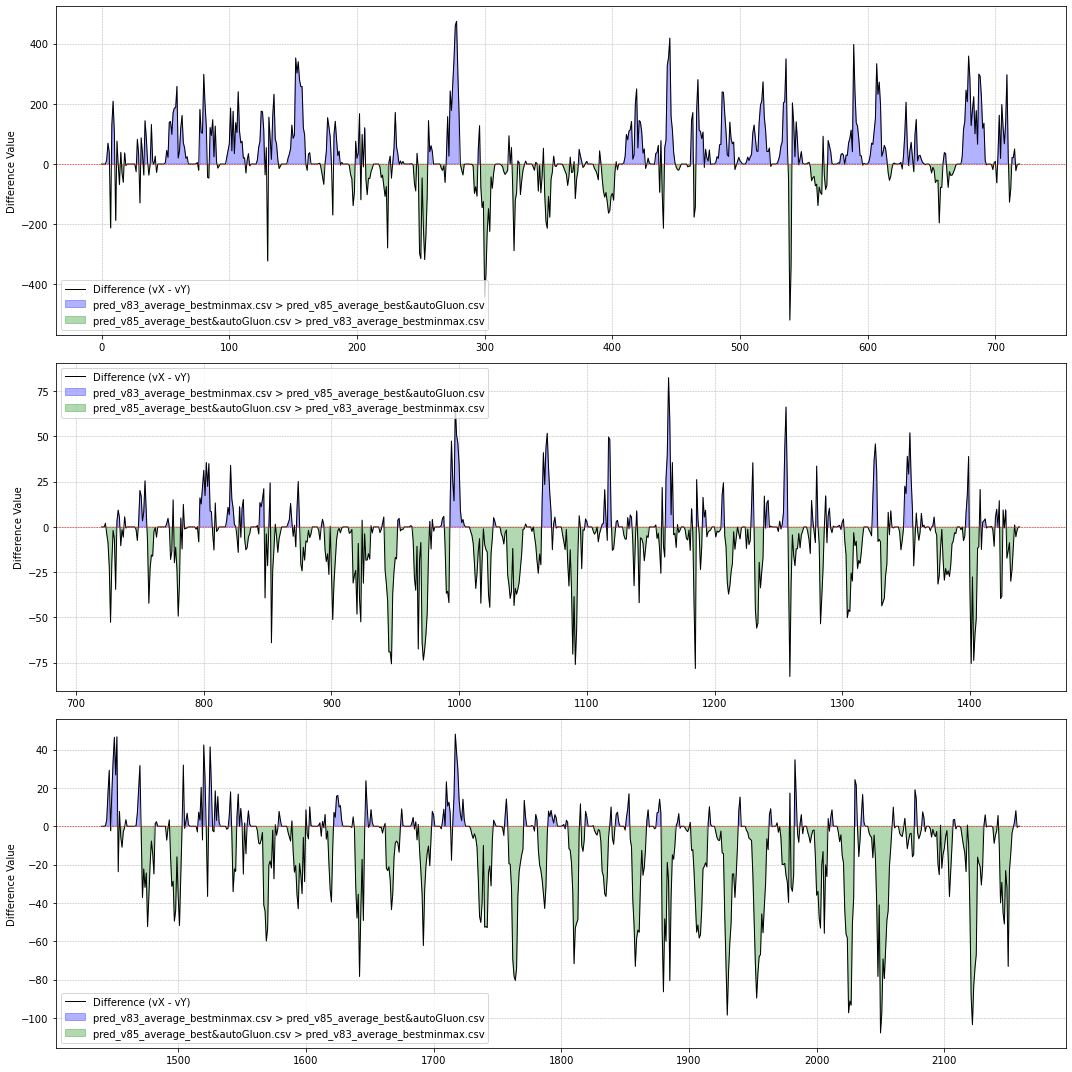

In [34]:
current_best = "pred_v83_average_bestminmax.csv"
eval = "pred_v85_average_best&autoGluon.csv"


df1 = pd.read_csv(current_best)
df2 = pd.read_csv(eval)

split_index = len(df1) // 3


df1_A = df1.iloc[:split_index]
df1_B = df1.iloc[split_index:2*split_index]
df1_C = df1.iloc[2*split_index:]

df2_A = df2.iloc[:split_index]
df2_B = df2.iloc[split_index:2*split_index]
df2_C = df2.iloc[2*split_index:]

def plot_difference(df1, df2):
    """Plot the difference between two dataframes' predictions."""
    diff = df1['prediction'] - df2['prediction']
    
    plt.plot(df1['id'], diff, label="Difference (vX - vY)", color="black", linewidth=1)
    
    # Highlight areas where Version X is greater than Version Y
    plt.fill_between(df1['id'], diff, where=(diff > 0), color='blue', alpha=0.3, label=f"{current_best} > {eval}")
    
    # Highlight areas where Version Y is greater than Version X
    plt.fill_between(df1['id'], diff, where=(diff < 0), color='green', alpha=0.3, label=f"{eval} > {current_best}")
    
    plt.axhline(0, color='red', linestyle="--", linewidth=0.5)
    plt.ylabel("Difference Value")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)


# Set up the plots
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

plt.sca(ax[0])
plot_difference(df1_A, df2_A)

plt.sca(ax[1])
plot_difference(df1_B, df2_B)

plt.sca(ax[2])
plot_difference(df1_C, df2_C)

plt.tight_layout()
plt.show()




In [80]:

def residual(single=False): 

    if not single:
        predict, model = train_predict(single=single)
        val_predict = pd.DataFrame(model.predict(X_val), columns=['prediction'])
        val_predict_proc = postprocessing(X_val, val_predict)
        residuals = Y_val - val_predict_proc['prediction']
        X_val['residuals'] = residuals
        residuals_A = residuals[X_val['location'] == 'A'].sum()
        residuals_B = residuals[X_val['location'] == 'B'].sum()
        residuals_C = residuals[X_val['location'] == 'C'].sum()

    else:
        predict, model_a, model_b, model_c, lenlist = train_predict(single=single)

        val_a_predict = pd.DataFrame(model_a.predict(X_val_a), columns=['prediction'])
        val_a_predict_proc = postprocessing(X_val_a, val_a_predict)
        residuals_A = (Y_val_a - val_a_predict_proc['prediction']).sum()

        val_b_predict = pd.DataFrame(model_b.predict(X_val_b), columns=['prediction'])
        val_b_predict_proc = postprocessing(X_val_b, val_b_predict)
        residuals_B = (Y_val_b - val_b_predict_proc['prediction']).sum()

        val_c_predict = pd.DataFrame(model_c.predict(X_val_c), columns=['prediction'])
        val_c_predict_proc = postprocessing(X_val_c, val_c_predict)
        residuals_C = (Y_val_c - val_c_predict_proc['prediction']).sum()

        # Keep original indices
        indices_A = Y_val_a.index
        indices_B = Y_val_b.index
        indices_C = Y_val_c.index
        
        residuals = pd.concat([Y_val_a - val_a_predict_proc['prediction'], Y_val_b - val_b_predict_proc['prediction'], Y_val_c - val_c_predict_proc['prediction']])

    # Use the original indices to filter the residuals
    print(f"Residual sum location A: {residuals_A}, per entry: {residuals_A/len(residuals.loc[indices_A])} (number of entries: {len(residuals.loc[indices_A])})")
    print(f"Residual sum location B: {residuals_B}, per entry: {residuals_B/len(residuals.loc[indices_B])} (number of entries: {len(residuals.loc[indices_B])})")
    print(f"Residual sum location C: {residuals_C}, per entry: {residuals_C/len(residuals.loc[indices_C])}  (number of entries: {len(residuals.loc[indices_C])})")
    print(f"Total residual sum: {residuals_A+residuals_B+residuals_C}")

residual(single=True)


/var/folders/ln/psx1xlb54d58wpx85ns5z98h0000gn/T/ipykernel_79840/652093100.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['location'].fillna('UNKNOWN', inplace=True)
/var/folders/ln/psx1xlb54d58wpx85ns5z98h0000gn/T/ipykernel_79840/652093100.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['location'].fillna('UNKNOWN', inplace=True)


0:	learn: 614.3323951	test: 622.2983900	best: 622.2983900 (0)	total: 17.9ms	remaining: 17.9s
1:	learn: 601.4274696	test: 609.4293063	best: 609.4293063 (1)	total: 29ms	remaining: 14.4s
2:	learn: 586.0216198	test: 594.1985100	best: 594.1985100 (2)	total: 39.7ms	remaining: 13.2s
3:	learn: 571.4336011	test: 580.3115465	best: 580.3115465 (3)	total: 50.8ms	remaining: 12.7s
4:	learn: 558.7709198	test: 568.1009154	best: 568.1009154 (4)	total: 60.7ms	remaining: 12.1s
5:	learn: 546.5069226	test: 556.2195038	best: 556.2195038 (5)	total: 70.8ms	remaining: 11.7s
6:	learn: 534.0120333	test: 544.1077549	best: 544.1077549 (6)	total: 81.4ms	remaining: 11.5s
7:	learn: 523.3045524	test: 533.9176813	best: 533.9176813 (7)	total: 92.4ms	remaining: 11.5s
8:	learn: 512.5793430	test: 523.4378513	best: 523.4378513 (8)	total: 103ms	remaining: 11.3s
9:	learn: 501.1333956	test: 512.3123121	best: 512.3123121 (9)	total: 115ms	remaining: 11.3s
10:	learn: 490.8359911	test: 502.2747420	best: 502.2747420 (10)	total: 126

/var/folders/ln/psx1xlb54d58wpx85ns5z98h0000gn/T/ipykernel_79840/652093100.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['location'].fillna('UNKNOWN', inplace=True)
/var/folders/ln/psx1xlb54d58wpx85ns5z98h0000gn/T/ipykernel_79840/652093100.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['location'].fillna('UNKNOWN', inplace=True)


5:	learn: 90.1884479	test: 91.4854090	best: 91.4854090 (5)	total: 67.1ms	remaining: 11.1s
6:	learn: 88.0344543	test: 89.2890773	best: 89.2890773 (6)	total: 77ms	remaining: 10.9s
7:	learn: 85.9258831	test: 87.1508531	best: 87.1508531 (7)	total: 87.5ms	remaining: 10.8s
8:	learn: 84.6373783	test: 85.8601596	best: 85.8601596 (8)	total: 96.5ms	remaining: 10.6s
9:	learn: 82.8467185	test: 84.0196848	best: 84.0196848 (9)	total: 107ms	remaining: 10.6s
10:	learn: 80.8973611	test: 81.9960025	best: 81.9960025 (10)	total: 116ms	remaining: 10.5s
11:	learn: 79.4001017	test: 80.4932250	best: 80.4932250 (11)	total: 126ms	remaining: 10.3s
12:	learn: 77.4757558	test: 78.5412925	best: 78.5412925 (12)	total: 135ms	remaining: 10.2s
13:	learn: 75.5188898	test: 76.5955707	best: 76.5955707 (13)	total: 144ms	remaining: 10.2s
14:	learn: 73.7288179	test: 74.7865617	best: 74.7865617 (14)	total: 154ms	remaining: 10.1s
15:	learn: 72.0462246	test: 73.0962617	best: 73.0962617 (15)	total: 163ms	remaining: 10s
16:	learn

/var/folders/ln/psx1xlb54d58wpx85ns5z98h0000gn/T/ipykernel_79840/652093100.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['location'].fillna('UNKNOWN', inplace=True)
/var/folders/ln/psx1xlb54d58wpx85ns5z98h0000gn/T/ipykernel_79840/652093100.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['location'].fillna('UNKNOWN', inplace=True)


2:	learn: 85.6004105	test: 92.3306655	best: 92.3306655 (2)	total: 30.3ms	remaining: 10.1s
3:	learn: 83.7420185	test: 90.3766873	best: 90.3766873 (3)	total: 39.2ms	remaining: 9.75s
4:	learn: 82.2284012	test: 88.7679028	best: 88.7679028 (4)	total: 53ms	remaining: 10.5s
5:	learn: 80.2526724	test: 86.6378679	best: 86.6378679 (5)	total: 62.1ms	remaining: 10.3s
6:	learn: 78.5222168	test: 84.7800817	best: 84.7800817 (6)	total: 70.8ms	remaining: 10s
7:	learn: 76.6937255	test: 82.7600870	best: 82.7600870 (7)	total: 79.9ms	remaining: 9.91s
8:	learn: 75.2619209	test: 81.2480301	best: 81.2480301 (8)	total: 88.6ms	remaining: 9.75s
9:	learn: 73.6806360	test: 79.4877611	best: 79.4877611 (9)	total: 97ms	remaining: 9.6s
10:	learn: 72.0062006	test: 77.7014850	best: 77.7014850 (10)	total: 105ms	remaining: 9.46s
11:	learn: 70.4717183	test: 76.0624499	best: 76.0624499 (11)	total: 114ms	remaining: 9.38s
12:	learn: 68.8861612	test: 74.3743737	best: 74.3743737 (12)	total: 122ms	remaining: 9.28s
13:	learn: 67.